# Methods of rolling ability scores

Characters in Pathfinder have 6 ability scores (strength, dexterity, constitution, intelligence, wisdom, charisma) and when one builds a character, there are several methods to generate these scores. These methods fall generally into two categories: rolling scores individually or generating a pool and assigning points.


#### Considered individually

In these methods you roll 6 scores and then assign them:

* Roll 4d6, sum the three largest (standard)
* Roll 4d6, reroll 1s, sum the three largest (what we did in college)
* Roll 3d6 and sum (classic)
* Roll 3d6, reroll 1s, sum (classic+)

#### Pool of points

In these methods, you have a pool of some kind and distribute the points among the different scores:

* 24d6, choose number of dice per stat and roll (dice pool)
  - same as above but 28d6 (heroic dice pool)
* Point buy: all ability scores start at 10, and you're given a certain number of points that can be distributed with increases "costing more" and decreases "refunding less" as you get to the extremes

For now, I'll focus on the methods where we roll scores individually.


Note: this is incomplete! I need to decide what I actually want to do to compare sets of stats, so I'll come back to it

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

# Set seed for reproducibility
rng = np.random.RandomState(0)

In [2]:
def roll_n_reroll_1s(n_dice, dice_sides):
    # returns a numpy array of size n_dice
    rolls = rng.randint(1,dice_sides+1, size=(n_dice))
    if np.any(rolls==1):
        rolls[rolls==1] = roll_n_reroll_1s(len(rolls[rolls==1]), dice_sides)
        return rolls
    else:
        return rolls
# This is fun, but it's got the same probability dist as for rolling a 
# d5 that has 2-6 on it, and that'll be faster, so skip this!
# (I want to keep it though, just 'cause)

## Rolling Scores Individually

In [3]:
how_many_stats = 600000
# so the eventual number of rows is divisible by 6

roll4 = rng.randint(1, 7, size=(how_many_stats,4))
roll4_no1 = rng.randint(2, 7, size=(how_many_stats,4))
roll3 = rng.randint(1, 7, size=(how_many_stats,3))
roll3_no1 = rng.randint(2, 7, size=(how_many_stats,3))

indiv_stats = pd.DataFrame({'standard': np.sum(roll4, axis=1)-np.min(roll4, axis=1),
                            'college': np.sum(roll4_no1, axis=1)-np.min(roll4_no1, axis=1),
                            'classic': np.sum(roll3, axis=1),
                            'classic_plus': np.sum(roll3_no1, axis=1)
                           })
indiv_stats.index.name = 'stat_roll'

### Comparing the distributions of individual scores

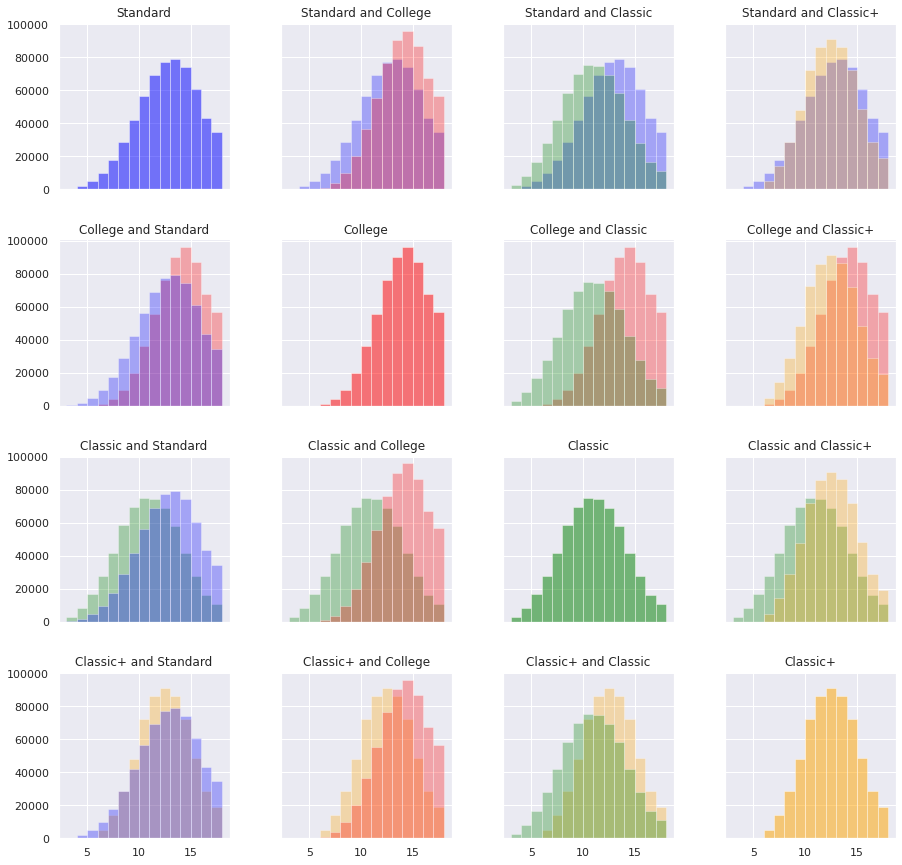

In [258]:
n=4 # 4x4 grid

# no rerolling, smallest possible score is 3, so there are 15 possible outcomes
# reroll 1s, smallest possible score is 6, so there are 12 possible outcomes
# of our 4 columns the even numbered ones are no rerolls, odd are rerolled
nbins = {0: 15, 1: 12}

# want consistent colors in the plots, based on which col of df
# standard = 0 = blue
# college = 1 = red
# classic = 2 = green
# classic+ = 3 = orange (might need to change this one
colors = {0: 'blue', 1: 'red', 2: 'green', 3: 'orange'}

# want good legend labels based on which column
# standard = 0
# college = 1 
# classic = 2
# classic+ = 3 
labels = {0: 'Standard', 1: 'College', 2: 'Classic', 3: 'Classic+'}


fig, ax = plt.subplots(n, n, sharex='col', sharey='row', figsize=(15,15))

for i in range(n):
    for j in range(n):
        indiv_stats.hist(column=indiv_stats.columns[i], 
                         ax=ax[i,j], 
                         alpha=0.3, bins=nbins[i%2],
                         color=colors[i], label=labels[i])
        indiv_stats.hist(column=indiv_stats.columns[j], 
                         ax=ax[i,j], 
                         bins=nbins[j%2], alpha=0.3, 
                         color=colors[j], label=labels[j])
        if i==j:
            ax[i,j].set_title(labels[i])
        else:
            ax[i,j].set_title(labels[i] + ' and ' + labels[j])

#fig.show()

### Sets of Scores

Now we'll take the rolled scores and put them in sets of 6 and then compare sets

In [98]:
sets_of_stats = indiv_stats.copy()

number_of_sets = (how_many_stats)/6

sets_of_stats['which_set'] = sets_of_stats.index%number_of_sets

sets_of_stats = sets_of_stats.sort_values(by='which_set').reset_index().drop(['stat_roll'],axis=1)
sets_of_stats

,standard,college,classic,classic_plus,which_set
0,15,15,4,11,0.0
1,15,14,11,11,0.0
2,8,16,9,12,0.0
3,13,11,10,10,0.0
4,12,17,15,12,0.0
...,...,...,...,...,...
599995,11,17,7,10,99999.0
599996,12,7,14,11,99999.0
599997,11,17,4,11,99999.0
599998,12,15,15,9,99999.0


In [57]:
sets_pivot = pd.pivot_table(sets_of_stats, 
                            values=sets_of_stats.columns[0:4], 
                            index='which_set', 
                            aggfunc=(lambda x: x.values.tolist())
                           )
sets_pivot

,classic,classic_plus,college,standard
which_set,,,,
0.0,"[4, 11, 15, 7, 10, 9]","[11, 11, 12, 11, 10, 12]","[15, 14, 17, 13, 11, 16]","[15, 15, 12, 13, 13, 8]"
1.0,"[14, 17, 10, 10, 10, 8]","[12, 10, 11, 10, 14, 9]","[12, 14, 11, 16, 11, 12]","[12, 8, 13, 10, 8, 14]"
2.0,"[17, 13, 5, 14, 8, 8]","[13, 12, 13, 9, 12, 13]","[17, 14, 12, 12, 16, 13]","[14, 11, 11, 12, 10, 18]"
3.0,"[13, 12, 12, 6, 8, 11]","[14, 10, 12, 7, 10, 16]","[15, 14, 15, 17, 14, 14]","[10, 13, 10, 11, 14, 14]"
4.0,"[13, 3, 14, 14, 11, 10]","[12, 12, 12, 10, 10, 14]","[12, 11, 11, 11, 16, 9]","[10, 13, 14, 10, 14, 10]"
...,...,...,...,...
99995.0,"[12, 13, 9, 16, 16, 11]","[12, 16, 13, 15, 14, 7]","[12, 11, 16, 16, 9, 15]","[9, 10, 16, 15, 13, 14]"
99996.0,"[14, 11, 11, 10, 14, 13]","[16, 14, 13, 14, 6, 16]","[12, 15, 17, 14, 9, 11]","[12, 16, 15, 10, 11, 12]"
99997.0,"[9, 9, 6, 14, 3, 8]","[14, 13, 14, 10, 10, 12]","[14, 15, 16, 14, 14, 18]","[9, 12, 15, 13, 17, 14]"


In [ ]:
three_d_array = np.array(sets_pivot.to_numpy().tolist())
three_to_two = np.sort(three_d_array, axis=2).reshape(100000,24)
three_to_two

In [107]:
which_set_stat = sets_of_stats.copy()

which_set_stat['which_stat'] = which_set_stat.index%6

which_set_stat = which_set_stat.melt(id_vars=['which_set','which_stat'], 
                                     value_vars=which_set_stat.columns[0:4],
                                     var_name='roll_style', value_name='roll'
                                    )
which_set_stat

,which_set,which_stat,roll_style,roll
0,0.0,0,standard,15
1,0.0,1,standard,15
2,0.0,2,standard,8
3,0.0,3,standard,13
4,0.0,4,standard,12
...,...,...,...,...
2399995,99999.0,1,classic_plus,10
2399996,99999.0,2,classic_plus,11
2399997,99999.0,3,classic_plus,11
2399998,99999.0,4,classic_plus,9


In [115]:
alt_sets_pivot = pd.pivot_table(which_set_stat, 
                            values=['roll'], 
                            index=['which_set','which_stat'], 
                            columns=['roll_style'],
                            aggfunc=(lambda x: x)
                           )
alt_sets_pivot

roll                              
roll_style           classic classic_plus college standard
which_set which_stat                                      
0.0       0                4           11      15       15
          1               11           11      14       15
          2                9           12      16        8
          3               10           10      11       13
          4               15           12      17       12
...                      ...          ...     ...      ...
99999.0   1                7           10      17       11
          2               14           11       7       12
          3                4           11      17       11
          4               15            9      15       12
          5                7           10      12       15

[600000 rows x 4 columns]

In [116]:
alt_sets_pivot.reset_index() #ugh no

which_set which_stat    roll                              
roll_style                      classic classic_plus college standard
0                0.0          0       4           11      15       15
1                0.0          1      11           11      14       15
2                0.0          2       9           12      16        8
3                0.0          3      10           10      11       13
4                0.0          4      15           12      17       12
...              ...        ...     ...          ...     ...      ...
599995       99999.0          1       7           10      17       11
599996       99999.0          2      14           11       7       12
599997       99999.0          3       4           11      17       11
599998       99999.0          4      15            9      15       12
599999       99999.0          5       7           10      12       15

[600000 rows x 6 columns]

hmmm, I need to think more about what visualization/stats/whatever I want to get out of this... I'll come back to it

In [58]:
# Assuming a 4 player party, let's look at balance
sets_pivot['player'] = sets_pivot.index%4
sets_pivot

,classic,classic_plus,college,standard,player
which_set,,,,,
0.0,"[4, 11, 15, 7, 10, 9]","[11, 11, 12, 11, 10, 12]","[15, 14, 17, 13, 11, 16]","[15, 15, 12, 13, 13, 8]",0.0
1.0,"[14, 17, 10, 10, 10, 8]","[12, 10, 11, 10, 14, 9]","[12, 14, 11, 16, 11, 12]","[12, 8, 13, 10, 8, 14]",1.0
2.0,"[17, 13, 5, 14, 8, 8]","[13, 12, 13, 9, 12, 13]","[17, 14, 12, 12, 16, 13]","[14, 11, 11, 12, 10, 18]",2.0
3.0,"[13, 12, 12, 6, 8, 11]","[14, 10, 12, 7, 10, 16]","[15, 14, 15, 17, 14, 14]","[10, 13, 10, 11, 14, 14]",3.0
4.0,"[13, 3, 14, 14, 11, 10]","[12, 12, 12, 10, 10, 14]","[12, 11, 11, 11, 16, 9]","[10, 13, 14, 10, 14, 10]",0.0
...,...,...,...,...,...
99995.0,"[12, 13, 9, 16, 16, 11]","[12, 16, 13, 15, 14, 7]","[12, 11, 16, 16, 9, 15]","[9, 10, 16, 15, 13, 14]",3.0
99996.0,"[14, 11, 11, 10, 14, 13]","[16, 14, 13, 14, 6, 16]","[12, 15, 17, 14, 9, 11]","[12, 16, 15, 10, 11, 12]",0.0
99997.0,"[9, 9, 6, 14, 3, 8]","[14, 13, 14, 10, 10, 12]","[14, 15, 16, 14, 14, 18]","[9, 12, 15, 13, 17, 14]",1.0


In [31]:
sets_pivot.iloc[0,0] = np.array(sets_pivot.iloc[0,0])

In [44]:
three_d_array = np.array(sets_pivot.to_numpy().tolist())
print(three_d_array.shape)
three_d_array

(100000, 4, 6)


array([[[ 4, 11, 15,  7, 10,  9],
        [11, 11, 12, 11, 10, 12],
        [15, 14, 17, 13, 11, 16],
        [15, 15, 12, 13, 13,  8]],

       [[14, 17, 10, 10, 10,  8],
        [12, 10, 11, 10, 14,  9],
        [12, 14, 11, 16, 11, 12],
        [12,  8, 13, 10,  8, 14]],

       [[17, 13,  5, 14,  8,  8],
        [13, 12, 13,  9, 12, 13],
        [17, 14, 12, 12, 16, 13],
        [14, 11, 11, 12, 10, 18]],

       ...,

       [[ 9,  9,  6, 14,  3,  8],
        [14, 13, 14, 10, 10, 12],
        [14, 15, 16, 14, 14, 18],
        [ 9, 12, 15, 13, 17, 14]],

       [[ 7,  6,  9, 11,  8,  8],
        [14, 13, 11, 11, 11, 17],
        [13, 12, 12, 16, 15, 18],
        [11,  4, 12, 15,  8, 12]],

       [[ 4, 14, 11,  7, 15,  7],
        [11, 11, 10, 10,  9, 10],
        [17,  7, 15, 17, 15, 12],
        [11, 12, 14, 11, 12, 15]]])

In [62]:
three_to_two = np.sort(three_d_array, axis=2).reshape(100000,24)
three_to_two

array([[ 4,  7,  9, ..., 13, 15, 15],
       [ 8, 10, 10, ..., 12, 13, 14],
       [ 5,  8,  8, ..., 12, 14, 18],
       ...,
       [ 3,  6,  8, ..., 14, 15, 17],
       [ 6,  7,  8, ..., 12, 12, 15],
       [ 4,  7,  7, ..., 12, 14, 15]])

In [104]:
big_df = pd.DataFrame(three_to_two)

In [105]:
big_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,4,7,9,10,11,15,10,11,11,11,...,14,15,16,17,8,12,13,13,15,15
1,8,10,10,10,14,17,9,10,10,11,...,12,12,14,16,8,8,10,12,13,14
2,5,8,8,13,14,17,9,12,12,13,...,13,14,16,17,10,11,11,12,14,18
3,6,8,11,12,12,13,7,10,10,12,...,14,15,15,17,10,10,11,13,14,14
4,3,10,11,13,14,14,10,10,12,12,...,11,11,12,16,10,10,10,13,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,9,11,12,13,16,16,7,12,13,14,...,12,15,16,16,9,10,13,14,15,16
99996,10,11,11,13,14,14,6,13,14,14,...,12,14,15,17,10,11,12,12,15,16
99997,3,6,8,9,9,14,10,10,12,13,...,14,15,16,18,9,12,13,14,15,17
99998,6,7,8,8,9,11,11,11,11,13,...,13,15,16,18,4,8,11,12,12,15
